# (2) Time series and piece-wise linearization

## Quick run

**Problem 2**: What is the optimal size of an electrolysis system and battery for an 10 MW wind turbine offgrid?

**OBS**: This example may take up to 3 min to run depending on your machine specifications

Running HiGHS 1.7.0 (git hash: 50670fd4c): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-01, 1e+04]
  Cost   [5e+00, 4e+04]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 1e+03]
Presolving model
3866 rows, 2186 cols, 10247 nonzeros  0s
3115 rows, 1604 cols, 8214 nonzeros  0s
2722 rows, 1398 cols, 7463 nonzeros  0s

Solving MIP model with:
   2722 rows
   1398 cols (456 binary, 0 integer, 0 implied int., 942 continuous)
   7463 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   74945.152151    -inf                 inf        0      0      0         0     0.0s
         0       0         0   0.00%   53002.057622    -inf                 inf        0      0      2      1302     0.1s
 C       0       0         0   0.00%   5

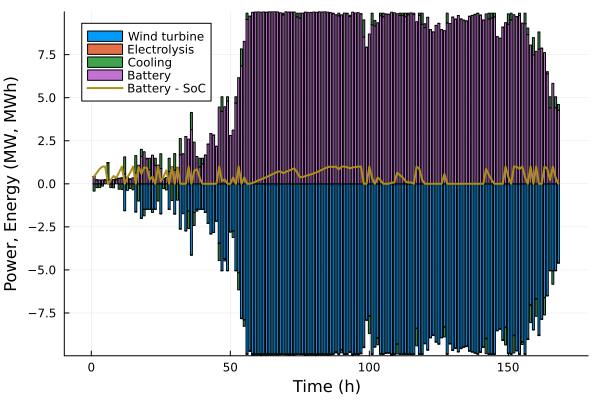

In [10]:
include("../../src/vivi.jl")
using CSV, DataFrames
using HiGHS
using StatsPlots

# Resource types
# Defining power input of electrolysis
hours = 24*7 # limiting analysis to one week
power = ResourceType(n="power",u="kW",c=zeros(hours,2))
power.c[:,2] = [1 for i = 1:hours]

h2 = ResourceType(n="h2",u="kg/h")
c_h2 = 5 # EUR/kg
hhv_h2 = 141.80E3/3600 # kWh/kg
h2.c = zeros(hours,2)
h2.c[:,1] = [c_h2 for i =1:hours]
h2.c[:,2] = [hhv_h2 for i =1:hours]

powerOut = ResourceType(n="power",u="kW",c=zeros(hours,2)) # Curtailment

# Defining hydrogen output of electrolysis
h2_out = Resource(t=h2,r=[18.67])
h2_out.pw = [
    0.15 0.18 
    0.51 0.55
    1.0 1.0
    ]
power_in = Resource(t=power,r=[940.7/0.95+2.7]) # Assuming 95% rectifier efficiency
power_in.pw = [
    0.15 0.15 
    0.51 0.51
    1 1
    ]
alk_in = [power_in]  
alk_out = [h2_out]
alk_q = [Heat(q=45.54,Ts=354, Tt=313),
        Heat(q=23.69, Ts=354, Tt=313),
        Heat(q=126.67, Ts=354, Tt=353),
        ]
alk = Tech(n="ALK",i=alk_in,o=alk_out,h=alk_q)

# Adding cost
i = 0.08
years = 20
CRF = (i/(1-(1+i)^(-years)))/8760 
alk_specific_cost = 1E6*CRF # EUR/h-kW
alk.c = [
    [0 0 
    100 100*alk_specific_cost]
    ]

# Adding size limits
alk.s = (8.0,15.0)

# Adding load limits and shutdown possibility
alk.l = (0.15,1)

# Wind turbine
# Electricity output
df = CSV.read("./hourWind.csv",DataFrame)
design_rating = 10E3
HWT = round.(df.load*design_rating,digits=3)
wt_out = [Resource(t=power,r=HWT[1:hours])]
wt = Tech(n="WT",o=wt_out)

# Adding costs
wt_cost = 20E6*CRF # EUR/h
wt.c = [
    [0 0
    1 wt_cost ]
    ]

# Limiting size
wt.s  = (1,1)

# Limiting load and shutdown
wt.l = (1,1)
wt.off = false

## Cooling tower
ct_in = [Resource(t=power,r=[14.3])]
ct_heat = [Heat(q=1000,Ts=298,Tt=318)]
ct = Tech(n="CT",i=ct_in,h=ct_heat) # It needs to check also the min loads with heats
ct.s = (1.0,3.0)

## Battery
battery = Storage(n="battery",t=power,a=0.0)
# Size limits
battery.s = (0.0,1.0E3)
# Cost data
bat_specific_cost = 302*CRF # EUR/kWhm

# Output
# Hydrogen
h2_out = Resource(t=h2,r=[Inf for i=1:hours])
# Curtailment
cut = Resource(t=powerOut,r=[Inf for i=1:hours])

# Problem
processes = [wt,alk]
utilities = [ct]
outputs = [h2_out,cut]
storage = [battery]
problem = Problem(p = [wt,alk], o = [h2_out,cut] , ut = [ct], st=[battery])
answer = vivi(problem,HiGHS.Optimizer,capex=true) # Gurobi solver is much faster

# Plotting
p = answer.p[1].f_t[1:hours] .* answer.p[1].o[1].r
e = -answer.p[2].f_t[1:hours]*(940.7/0.95+2.7)
u = -answer.ut[1].f_t[1:hours]*14.3
b = -[answer.st[1].f_t[1]-answer.st[1].a]
b = vcat(b,-[answer.st[1].f_t[i] - answer.st[1].f_t[i-1] for i=2:hours])
all = reshape(vcat(e,u,b,p),(hours,4)) / 1000
groupedbar(all, bar_position = :stack, bar_width=0.7,label=["Wind turbine" "Electrolysis" "Cooling" "Battery"])
plot!(answer.st[1].f_t/1000,lw=2,label="Battery - SoC")
xaxis!("Time (h)")
yaxis!("Power, Energy (MW, MWh)")

## Explanation

### Including vivi

Let's import the vivi functions and structures that will help us to solve the problem

In [26]:
include("../../src/vivi.jl")
using CSV, DataFrames
using HiGHS
using StatsPlots

## Resource types

In [13]:
# Resource types
# Defining power input of electrolysis
hours = 24*7 # limiting analysis to one week
power = ResourceType(n="power",u="kW",c=zeros(hours,2))
power.c[:,2] = [1 for i = 1:hours]

h2 = ResourceType(n="h2",u="kg/h")
c_h2 = 5 # EUR/kg
hhv_h2 = 141.80E3/3600 # kWh/kg
h2.c = zeros(hours,2)
h2.c[:,1] = [c_h2 for i =1:hours]
h2.c[:,2] = [hhv_h2 for i =1:hours]

powerOut = ResourceType(n="power",u="kW",c=zeros(hours,2)) # Curtailment

ResourceType("power", Real[0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0], "kW")

## Techs

### Alkaline electrolysis

Alkaline electrolysis efficiency varies with load. We can add this detail by modifying the **pw** attribute in resources:


            resource.pw = [
                load_1  percentage_1
                load_2  percentage_2
                ...
            ]

In this case, **percentage** refers to the percentage of the resource amount that is produced at that specific load point.

In [14]:
# Defining hydrogen output of electrolysis
h2_out = Resource(t=h2,r=[18.67])
h2_out.pw = [
    0.15 0.18 
    0.51 0.55
    1.0 1.0
    ]
power_in = Resource(t=power,r=[940.7/0.95+2.7]) # Assuming 95% rectifier efficiency
power_in.pw = [
    0.15 0.15 
    0.51 0.51
    1 1
    ]
alk_in = [power_in]  
alk_out = [h2_out]
alk_q = [Heat(q=45.54,Ts=354, Tt=313),
        Heat(q=23.69, Ts=354, Tt=313),
        Heat(q=126.67, Ts=354, Tt=353),
        ]
alk = Tech(n="ALK",i=alk_in,o=alk_out,h=alk_q)

Tech("ALK", Resource[Resource(ResourceType("power", Real[0.0 1; 0.0 1; … ; 0.0 1; 0.0 1], "kW"), Real[992.9105263157896], Real[0.15 0.15; 0.51 0.51; 1.0 1.0])], Resource[Resource(ResourceType("h2", Real[5 39.388888888888886; 5 39.388888888888886; … ; 5 39.388888888888886; 5 39.388888888888886], "kg/h"), Real[18.67], Real[0.15 0.18; 0.51 0.55; 1.0 1.0])], Heat[Heat(45.54, 354, 313, 7.5, Real[0 0; 1 1], "-"), Heat(23.69, 354, 313, 7.5, Real[0 0; 1 1], "-"), Heat(126.67, 354, 353, 7.5, Real[0 0; 1 1], "-")], Matrix{Real}[[0.0 0.0; 1000.0 0.0]], (0, 1000.0), (0, 1), (-1, 1), true, 1, Real[1])

In addition each Tech has a number of attributes which we can set to better represent the problem:

* **s**: specify the size limits of the technology

                tech.s = [min,max] # min <= size <= max 

* **c**: specify the cost data for different sizes of the technology

                tech.c = [
                    [
                        size_1 cost_1
                        size_2 cost_2
                        ...
                    ],
                    ...     # in the case there is more than one type of cost/value
                ]

* **l**: specify the minimal/maximum load of the technology and if it can be shutted off.

                tech.l = [min,max] # min <= load <= max
* **off**:

                tech.off = true/false
    * if **on_off** is *true*, then the technology can be shut down (i.e. load == 0 is valid)
    * if **on_off** is *false*, then the technology cannot be shut down (i.e. load != 0)

In our case, we would like to add the following caracteristics:
* Specific cost = 1 MEUR / kW
* Size limits = 8-15x
* Load limits = 0% or 15-100% (with shutdown)

In [15]:
# Adding cost
i = 0.08
years = 20
CRF = (i/(1-(1+i)^(-years)))/8760 
alk_specific_cost = 1E6*CRF # EUR/h-kW
alk.c = [
    [0 0 
    100 100*alk_specific_cost]
    ]

# Adding size limits
alk.s = (8.0,15.0)

# Adding load limits and shutdown possibility
alk.l = (0.15,1)

alk.off = true

true

### Wind turbine

Similarly, we can define a wind turbine as a Tech that outputs different amounts of electricity per hour. In this analysis we will limit the number of hours to 168 (one week) in order to solve the optimization quickly.
* Specific cost = 2 MEUR / MW
* Size limits = 1x
* Load limits = 100% (without shutdown)

In [16]:
# Electricity output
df = CSV.read("./hourWind.csv",DataFrame)
design_rating = 10E3
HWT = round.(df.load*design_rating,digits=3)
wt_out = [Resource(t=power,r=HWT[1:hours])]
wt = Tech(n="WT",o=wt_out)

# Adding costs
wt_cost = 20E6*CRF # EUR/h
wt.c = [
    [0 0
    1 wt_cost ]
    ]

# Limiting size
wt.s  = (1,1)

# Limiting load and shutdown
wt.l = (1,1)
wt.off = false

false

**OBS**: Note that we are limiting the size of the wind turbine to 1 because the size is fixed to 10 MW. In addition loads are fixed to 100% without the possibility of shutdown because the power output already accounts for the turbine loads and shutdown effects. 

### Cooling tower

A cooling water can be added as a simple Tech with a heat sink. For simplicity we are not going to consider the costs and partial load efficiencies of the coolwing tower.

In [17]:
ct_in = [Resource(t=power,r=[14.3])]
ct_heat = [Heat(q=1000,Ts=298,Tt=318)]
ct = Tech(n="CT",i=ct_in,h=ct_heat) # It needs to check also the min loads with heats
ct.s = (1.0,3.0)

(1.0, 3.0)

### Battery

Storages in vivi are perfect reservoirs of resources that can have a cost associated with it. The construction is simple:

                store = Storage(
                    n = Storage name
                    t = Resource type
                    a = initial amount
                    )

As it with Techs, we can set the min-max sizes and costs for the storage. For a simple battery, for instance:

In [18]:
battery = Storage(n="battery",t=power,a=0.0)
# Size limits
battery.s = (0.0,1.0E3)
# Cost data
bat_specific_cost = 302*CRF # EUR/kWhm

0.0035113432722136385

## Output

The two outputs that we are going to consider in this analysis are the hydrogen and the curtailment of electricity:

In [19]:
# Hydrogen
h2_out = Resource(t=h2,r=[Inf for i=1:hours])
# Curtailment
cut = Resource(t=powerOut,r=[Inf for i=1:hours])

Resource(ResourceType("power", Real[0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0], "kW"), Real[Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf  …  Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], Real[0 0; 1 1])

**OBS**: Note that we have to define an amount and value for each hour of the analysis

## Problem and solution

In this case, since there are lots of variables, the problem may take a while to solve. In addition, we should make it explicit to the solver that we would like to use the CAPEX estimations:

In [21]:
processes = [wt,alk]
utilities = [ct]
outputs = [h2_out,cut]
storage = [battery]
problem = Problem(p = [wt,alk], o = [h2_out,cut] , ut = [ct], st=[battery])
answer = vivi(problem,HiGHS.Optimizer,capex=true)

Running HiGHS 1.7.0 (git hash: 50670fd4c): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-01, 1e+04]
  Cost   [5e+00, 4e+04]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 1e+03]
Presolving model
3866 rows, 2186 cols, 10247 nonzeros  0s
3115 rows, 1604 cols, 8214 nonzeros  0s
2722 rows, 1398 cols, 7463 nonzeros  0s

Solving MIP model with:
   2722 rows
   1398 cols (456 binary, 0 integer, 0 implied int., 942 continuous)
   7463 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   74945.152151    -inf                 inf        0      0      0         0     0.0s
         0       0         0   0.00%   53002.057622    -inf                 inf        0      0      2      1302     0.0s
 C       0       0         0   0.00%   5

Problem(Resource[], Resource[Resource(ResourceType("h2", Real[5 39.388888888888886; 5 39.388888888888886; … ; 5 39.388888888888886; 5 39.388888888888886], "kg/h"), Real[-2.724197683059945e-16, -3.258712526462427e-16, 5.477218173157761e-16, 1.2235374297456661e-15, 1.1339222581808608e-16, -8.65437717978447e-16, 0.0, -5.461110848073095e-16, -1.0355260567055759e-15, 0.0  …  161.30330284211163, 130.3959888455019, 166.98849220212318, 150.73209311301144, 129.10479969561248, 127.28504022619227, 102.16419973881162, 102.16419973881156, 102.16419973881162, 93.64284746688134], Real[0 0; 1 1]), Resource(ResourceType("power", Real[0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0], "kW"), Real[1.582018520573662e-14, -1.1511997672302543e-14, 0.0, 92.63699999999996, 219.972, 1217.2, 0.0, 0.0, 322.9840000000001, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Real[0 0; 1 1])], Tech[Tech("WT", Resource[], Resource[Resource(ResourceType("power", Real[0.0 1; 0.0 1; … ; 0.0 1; 0.0 1], "kW"), Real[422.778, 

The solution gives the optimal sizes for the system components. The maximum revenue is estimated as **51,0517 EUR/week** for the cost and wind power profile assumed.

What is interesting to observe is that the size of the AEC system is slighly undersized, as it can be observed by plotting energy produced/consumed by the system:

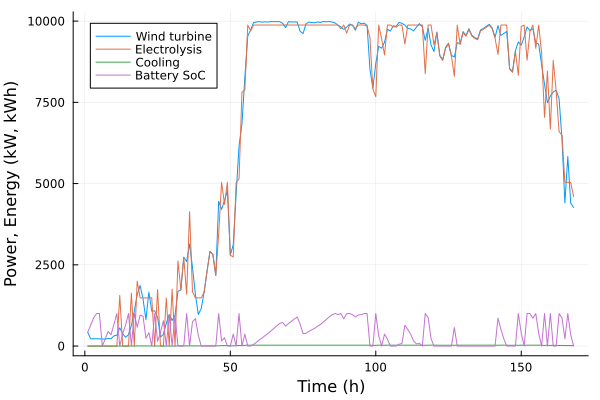

In [23]:
# Plotting first 10 days
plot(HWT[1:hours],label="Wind turbine",xlabel="hour",ylabel="Energy (kW or kWh)")
plot!(answer.p[2].f_t*(940.7/0.95+2.7),label="Electrolysis")
plot!(answer.ut[1].f_t*14.3,label="Cooling")
plot!(answer.st[1].f_t,label="Battery SoC")

xaxis!("Time (h)")
yaxis!("Power, Energy (kW, kWh)")

**Example**: plotting the Sankey diagram for time = 150 using the second value index (energy)

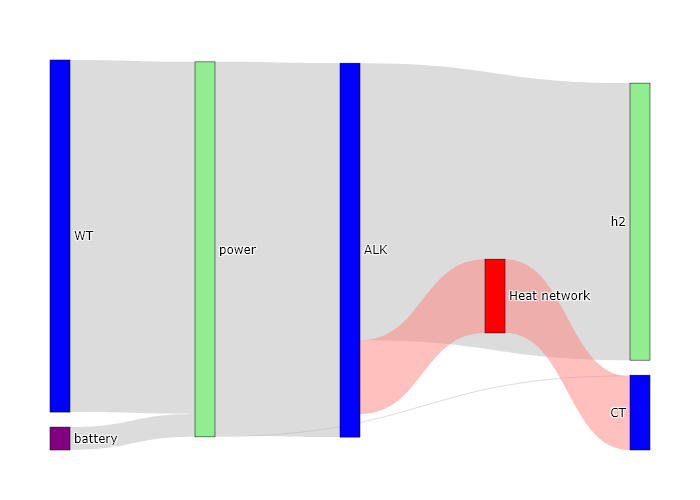

In [28]:
vivi_sankey(answer,valueIndex=2,time=150)

**Example**: plotting the composite curve for time = 150

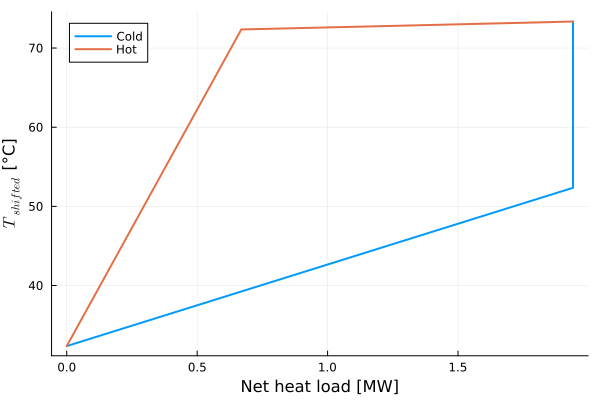

In [30]:
vivi_cc(answer,HiGHS.Optimizer,time = 150)